In [40]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
# Dependencies
import csv
import matplotlib.pyplot as plt
import openweathermapy as ow
import pandas as pd
from pprint import pprint
from datetime import date
import json
from datetime import date
import calendar
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.stats as stats

In [41]:
# Function to plot the bubble graph. It allows for changing the x, y axises and the s (area)
def bubbleplot(df, x_dim, y_dim, s_dim, classes):
   x  = df[x_dim]
   y  = df[y_dim]
   s  = df[s_dim]*20
   ct = df[classes]
   unique_city_type = ct.unique()
   ct_colors ={"Theft Over":"#FF7F50", "Robbery":"#76D7EA","Break and Enter":"#FFD700","Assault":"#A10C4D","Auto Theft":"#6195ED"}
   figsize=(10,10)
   fig, ax = plt.subplots(figsize=figsize)

   for i, city_type in enumerate(unique_city_type):
       xi = [x[j] for j  in range(len(x)) if ct[j] == city_type]
       yi = [y[j] for j  in range(len(x)) if ct[j] == city_type]
       si = [s[j] for j  in range(len(x)) if ct[j] == city_type]
       plt.scatter(x=xi, y=yi, s=si, c=ct_colors[city_type], label=str(city_type),
                   alpha=0.8, linewidths=0.5, edgecolors="black")

       #print(f"i = {i} |(xi,yi,si) points = {len(xi)} | city_type = {city_type} ")

   lgnd = plt.legend(frameon=True,title=classes,loc="upper right")
   for handle in lgnd.legendHandles:
       handle.set_sizes([20])

   ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.8)
   ax.set_title('Major Crime Indicator of Toronto Police')
   ax.set_xlabel(f'{x_dim} (Per City)')
   ax.set_ylabel(y_dim)

   #note = f"Note:\nCircle size correlates to \n{s_dim}"
   #plt.text(0.6, 0.7, note, fontsize=10, transform=plt.gcf().transFigure)
   plt.tight_layout()

   #print(f"{x_dim} (min:max) ({x.min()}:{x.max()})\n{y_dim} (min:max) ({y.min()}:{y.max()})\n{s_dim} (min:max) ({s.min()}:{s.max()})")
   bubble_file_name = f"Resources/bubbleplot_{s_dim}.png"
   plt.savefig( bubble_file_name, )
   
   plt.show()
    

In [42]:
def expmovingaverage(values, window):
    weights = np.exp(np.linspace(-1.,0.,window))
    weights /= weights.sum()
    a = np.convolve(values, weights)[:len(values)]
    a[:window] = a[window]
    return(a)

In [43]:
def run_anova(df, indexcol, pivotcol):
    # Receives the dataframe, the index column and the pivot column
    # and create a new pivoted dataframe  to be used to create the groups
    # that will be compared in the Anova test
    
    # Group by both index and pivot columns and count the number of crimes
    df_anova = df.groupby([pivotcol,indexcol])["ObjectId"].agg([("MCI count","count")]).\
                reset_index(None)
    
    # Set the index to indexcol                                          
    df_anova = df_anova.set_index(indexcol)
    
    # Pivot the grouped by dataframe on the pivotcol
    df_pivot = df_anova.pivot(columns=pivotcol,values="MCI count")
    
    # Return both the dataframe and the pvalue for all the groups of values
    return df_pivot, \
           stats.f_oneway(*[[df_pivot[col].iloc[row] for col in df_pivot.columns] \
                            for row in range(len(df_pivot))])[1]


In [44]:
##Read the Data from already processed datafile
MCI_df = pd.read_csv("Resources/MCI_2014_to_2018_full.csv")[['ObjectId','MCI','occurrencedate','premisetype','wardnumber', 'wardname','wardmedian']]
MCI_df.reset_index(None)
# Looking only at strikers (ST) to start
MCI_df["occurencedate_weekday"]=pd.to_datetime(MCI_df["occurrencedate"],format="%Y/%m/%d").dt.weekday
MCI_df["occurencedate_dayname"]=pd.to_datetime(MCI_df["occurrencedate"],format="%Y/%m/%d").dt.day_name()
MCI_df["occurence hour of days"]=pd.to_datetime(MCI_df["occurrencedate"],format="%Y/%m/%d").dt.hour
MCI_df["wardname"]=MCI_df['wardname'].str.strip() + ' (' + MCI_df['wardnumber'].astype(str) + ')'
MCI_df.head(5)

,ObjectId,MCI,occurrencedate,premisetype,wardnumber,wardname,wardmedian,occurencedate_weekday,occurencedate_dayname,occurence hour of days
0,99462,Break and Enter,2015-04-08T17:15:00.000Z,House,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,2,Wednesday,17
1,140047,Assault,2016-03-06T15:00:00.000Z,House,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,6,Sunday,15
2,2404,Assault,2014-06-14T20:00:00.000Z,Outside,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,5,Saturday,20
3,48420,Assault,2015-08-13T03:30:00.000Z,Outside,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,3,Thursday,3
4,63103,Assault,2016-08-22T23:45:00.000Z,Outside,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,0,Monday,23


In [45]:
MCI_df.sample(frac=0.001)[['ObjectId','MCI','premisetype','occurencedate_dayname','occurence hour of days','wardnumber', 'wardname','wardmedian']].\
to_html("MCI data.html", index=False)

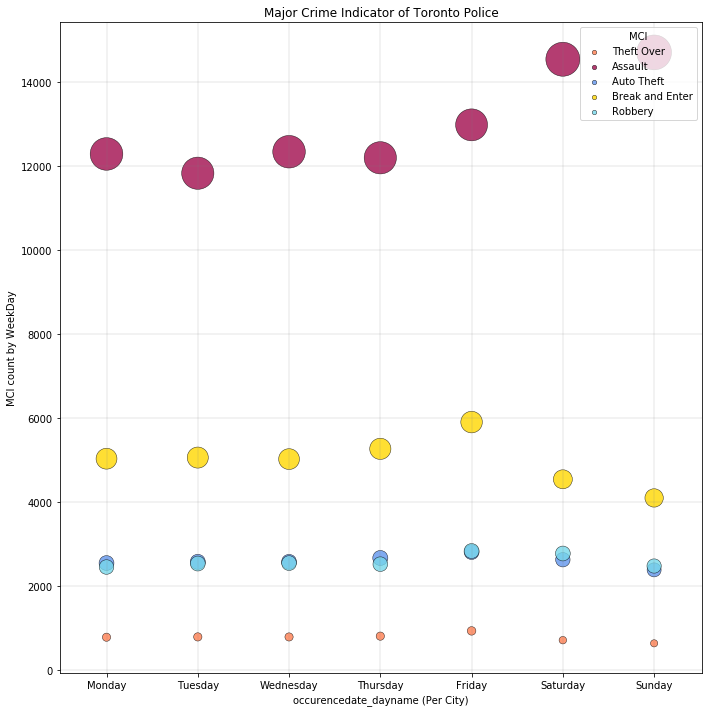

In [46]:
##Analysis for MCI indicator by days of week
total_offence = len(MCI_df)
MCI_df_Groupby_Day_and_MCI=MCI_df.groupby(["occurencedate_dayname","occurencedate_weekday","MCI"])["ObjectId"].agg([("MCI count by WeekDay","count")\
                                                                               ]).reset_index("MCI")
MCI_df_Groupby_Day=MCI_df.groupby(["occurencedate_dayname","occurencedate_weekday"])["ObjectId"].agg([("MCI sum by WeekDay","count")\
                                                                               ])
#MCI_df_Group.to_csv("Resources/Group_by_MCI.csv")
MCI_df_Groupby_all=pd.merge(MCI_df_Groupby_Day_and_MCI,MCI_df_Groupby_Day,on=["occurencedate_weekday","occurencedate_dayname"]).reset_index(None)
MCI_df_Groupby_all=MCI_df_Groupby_all.sort_values("occurencedate_weekday")
MCI_df_Groupby_all["Percentage of Crime"]=MCI_df_Groupby_all["MCI count by WeekDay"]/MCI_df_Groupby_all["MCI sum by WeekDay"]*100

MCI_df_Groupby_all=MCI_df_Groupby_all.reset_index(None)
bubbleplot(MCI_df_Groupby_all,"occurencedate_dayname","MCI count by WeekDay","Percentage of Crime","MCI")



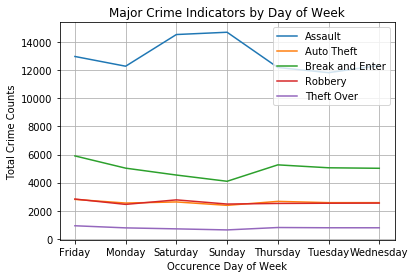

In [47]:

MCI_df_Groupby_dow=MCI_df.groupby(["occurencedate_dayname","MCI"])["ObjectId"].agg([("MCI count by day","count")]).reset_index(None)
MCI_df_Groupby_dow=MCI_df_Groupby_dow.set_index("MCI")
MCI_df_Groupby_dow
MCI_df_Groupby_dow_pivot=MCI_df_Groupby_dow.pivot(columns="occurencedate_dayname",values="MCI count by day")
for i in range(len(MCI_df_Groupby_dow_pivot)):
   plt.plot([k for k in MCI_df_Groupby_dow_pivot.columns],[MCI_df_Groupby_dow_pivot[y].iloc[i] for y in MCI_df_Groupby_dow_pivot.columns])
plt.legend(MCI_df_Groupby_dow_pivot.index,loc="upper right")
plt.xlabel("Occurence Day of Week")
plt.ylabel("Total Crime Counts")
plt.grid()
plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.title("Major Crime Indicators by Day of Week")
plt.savefig("Resources/Crime based on dow1.png")
plt.show()

# Null Hypothesis is no relation between crime and day of week
The p-value is lower the 0.05 hence we can reject the NULL hypothesis. THe crime and day of week is statistically  significant 

In [61]:
#Anova test for Days of week crime indicator(MCI)
# MCI_df_anova_daysofweek=MCI_df.groupby(["MCI","occurencedate_dayname"])["ObjectId"].agg([("MCI count by WeekDay","count")])
                                                                        
# MCI_df_anova_daysofweek=MCI_df_anova_daysofweek.reset_index(None)
# MCI_df_anova_daysofweek=MCI_df_anova_daysofweek.set_index("MCI")
# MCI_df_anova_daysofweek_pivot=MCI_df_anova_daysofweek.pivot(columns='occurencedate_dayname',values="MCI count by WeekDay")
# MCI_df_anova_daysofweek_pivot
# groups_days=[]
# for i in range(len(MCI_df_anova_daysofweek_pivot)):
#     groups_days.append([MCI_df_anova_daysofweek_pivot[y].iloc[i] for y in MCI_df_anova_daysofweek_pivot.columns])

# stats.f_oneway(groups_days[0], groups_days[1], groups_days[2], groups_days[3], groups_days[4])
df_result, pvalue = run_anova(MCI_df, "MCI", "occurencedate_dayname")
df_result.to_html("dow_pivot_mci.html")
print(f"pvalue = {pvalue}")


df_result, pvalue = run_anova(MCI_df, "occurencedate_dayname", "MCI")
df_result.to_html("dow_pivot_mci.html")
print(f"pvalue = {pvalue}")


pvalue = 1.5137362091572156e-26
pvalue = 0.9999953803301733


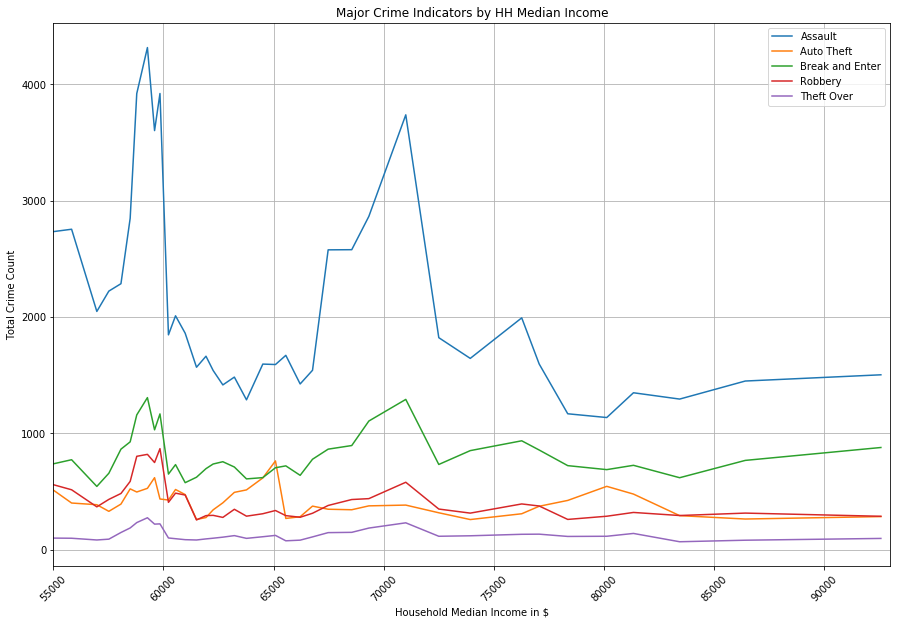

In [49]:
# Analysis by ward
MCI_df_Groupby_ward=MCI_df.groupby(["wardnumber","wardname","MCI"])["ObjectId"].agg([("MCI count by ward","count")\
                                                                              ]).join\
(MCI_df.groupby(["wardnumber","wardname","MCI"])["wardmedian"].agg([("Household Median Income","min")\
                                                                              ]))

MCI_df_Groupby_ward

MCI_df_Groupby_ward=MCI_df_Groupby_ward.reset_index(None)#("wardnumber").set_index("MCI")
MCI_df_Groupby_ward=MCI_df_Groupby_ward.set_index("MCI")

MCI_df_Groupby_ward_pivot=MCI_df_Groupby_ward.pivot(columns='Household Median Income',values="MCI count by ward")
MCI_df_Groupby_ward_pivot

for i in range(len(MCI_df_Groupby_ward_pivot)):
   mci = [k for k in MCI_df_Groupby_ward_pivot.columns],[MCI_df_Groupby_ward_pivot[y].iloc[i] for y in MCI_df_Groupby_ward_pivot.columns]
   fig = plt.plot(expmovingaverage(mci[0], 4),expmovingaverage(mci[1], 4))
plt.legend(MCI_df_Groupby_ward_pivot.index,loc="upper right")
plt.xticks(np.arange(55000, 93000 + 5000, 5000) , rotation = 45)
plt.xlabel("Household Median Income in $")
plt.ylabel("Total Crime Count")
plt.xlim(55000, 93000)
plt.grid()
plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.title("Major Crime Indicators by HH Median Income")
plt.savefig("Resources/Crime Analysis by Household Median Income1.png")
plt.show()




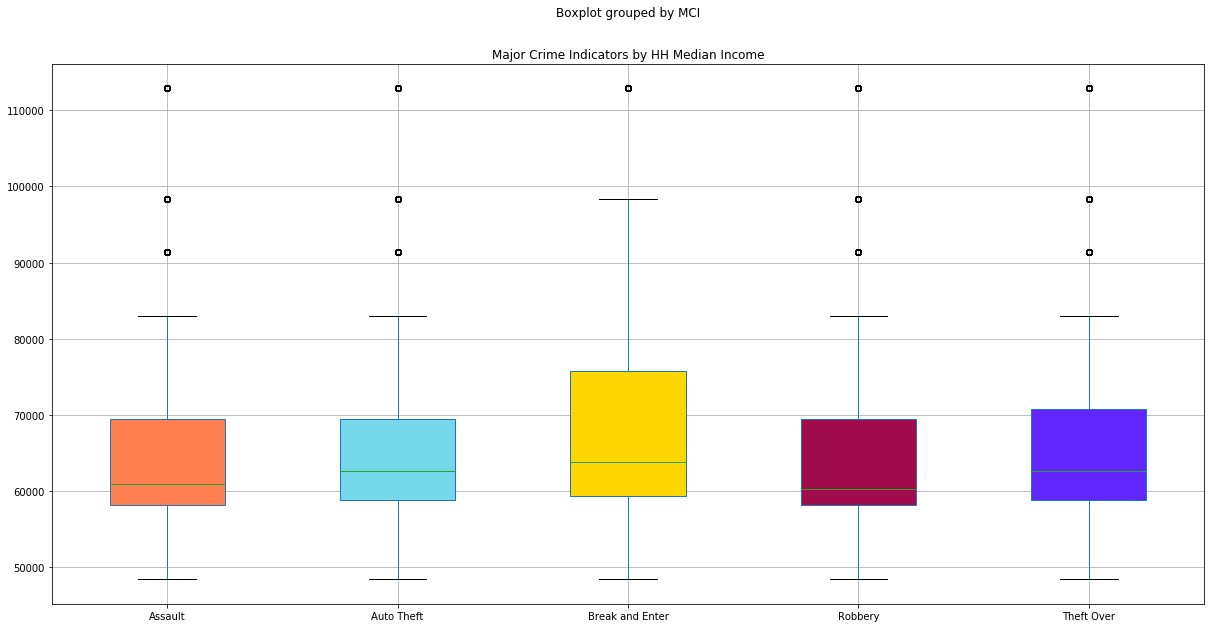

In [50]:
#Crime median based on household income

box=MCI_df.boxplot("wardmedian", by="MCI", figsize=(20, 10),return_type='both',patch_artist = True,)



colors =["#FF7F50","#76D7EA","#FFD700","#A10C4D","#6125FD"]
#colors = ['cyan', 'lightblue', 'lightgreen', 'tan', 'pink']
for row_key, (ax,row) in box.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.title("Major Crime Indicators by HH Median Income")
plt.savefig("Resources/Crime Median Household1.png")
plt.show()

# Null hypothesis  is the crime has no significance based on wards ?

P-value ≤ o.05:  you reject the null hypothesis and conclude that the crime has significance with ward

In [51]:
#Anova test for crime as per the wards

# MCI_df_anova_pivot=MCI_df_Groupby_ward.pivot(columns='wardname',values="MCI count by ward")

# groups=[]
# for i in range(len(MCI_df_anova_pivot)):
#     groups.append([MCI_df_anova_pivot[y].iloc[i] for y in MCI_df_anova_pivot.columns])
# stats.f_oneway(groups[0], groups[1], groups[2], groups[3], groups[4])
df_result, pvalue = run_anova(MCI_df, "MCI", "wardmedian")
df_result.to_html("ward_pivot_mci.html")
print(f"pvalue = {pvalue}")

df_result, pvalue = run_anova(MCI_df, "wardmedian", "MCI")
df_result.to_html("ward_pivot_mci.html")
print(f"pvalue = {pvalue}")

pvalue = 2.6781825793277983e-33
pvalue = 0.5710328536406233


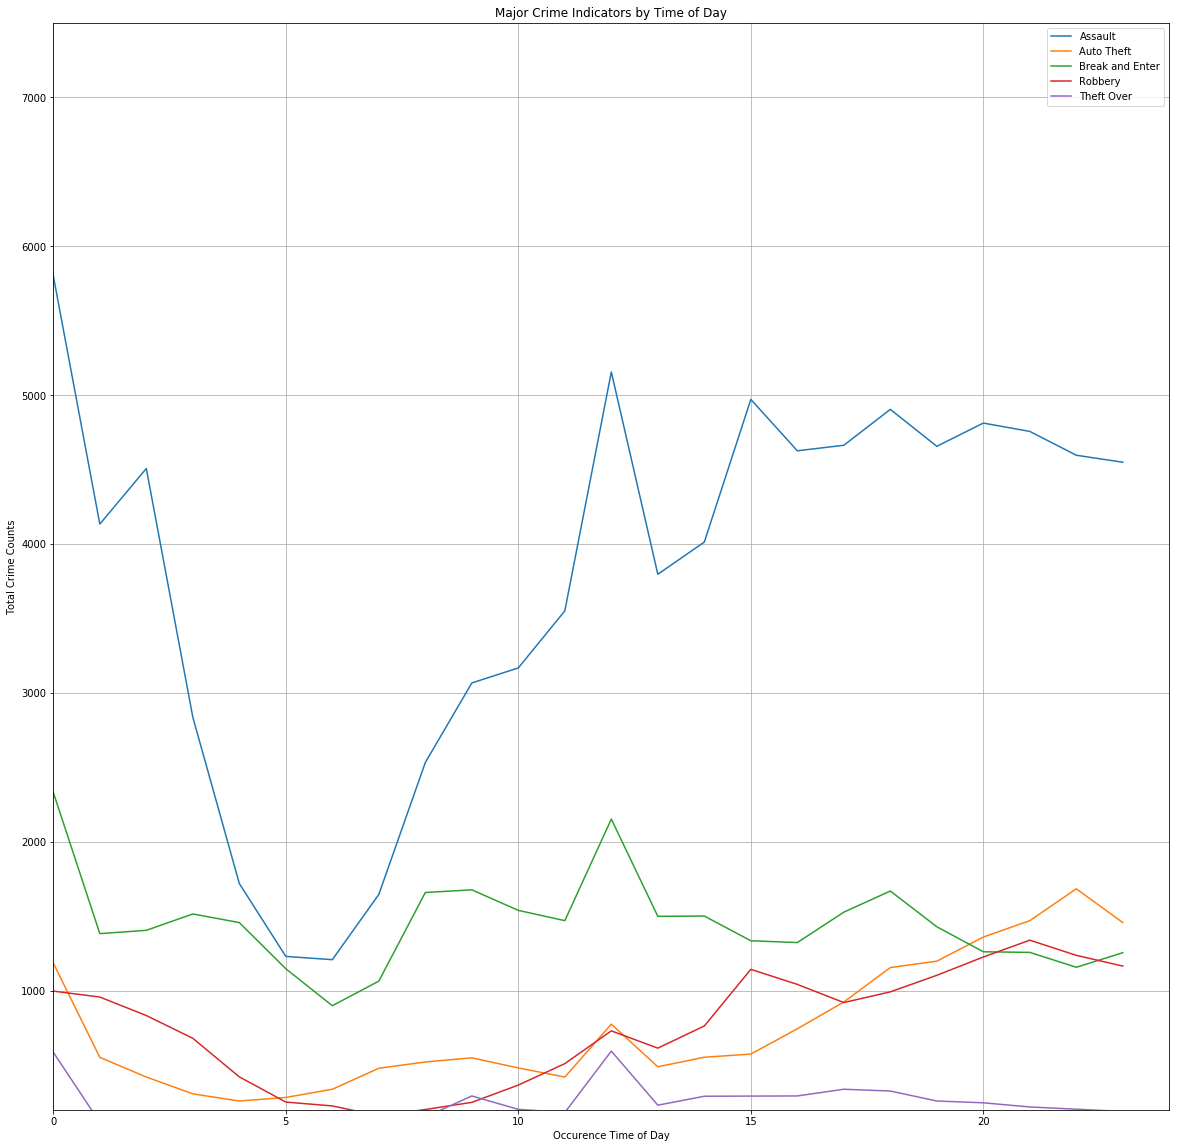

In [52]:

MCI_df_Groupby_hours=MCI_df.groupby(["occurence hour of days","MCI"])["ObjectId"].agg([("MCI count by hour","count")]).reset_index(None)
MCI_df_Groupby_hours=MCI_df_Groupby_hours.set_index("MCI")
MCI_df_Groupby_hours
MCI_df_Groupby_hours_pivot=MCI_df_Groupby_hours.pivot(columns='occurence hour of days',values="MCI count by hour")
for i in range(len(MCI_df_Groupby_hours_pivot)):
   plt.plot([k for k in MCI_df_Groupby_hours_pivot.columns],[MCI_df_Groupby_hours_pivot[y].iloc[i] for y in MCI_df_Groupby_hours_pivot.columns])
plt.legend(MCI_df_Groupby_hours_pivot.index,loc="upper right")
plt.xlim(0,24)
plt.xlabel("Occurence Time of Day")
plt.ylabel("Total Crime Counts")
plt.ylim(200,7500)
plt.grid()
plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.title("Major Crime Indicators by Time of Day")
plt.savefig("Resources/Crime based on hours of day1.png")
plt.show()

# The Null Hypothesis is the hour of day has no significance on crime
The lower p value rejects the NULL hypothesis

In [53]:
#Anova test for occurance hour of crime

# MCI_df_Groupby_hours_pivot
# groups_hours=[]
# for i in range(len(MCI_df_Groupby_hours_pivot)):
#     groups_hours.append([MCI_df_Groupby_hours_pivot[y].iloc[i] for y in MCI_df_Groupby_hours_pivot.columns])
# stats.f_oneway(groups_hours[0], groups_hours[1], groups_hours[2], groups_hours[3], groups_hours[4])
df_result, pvalue = run_anova(MCI_df, "MCI", "occurence hour of days")
df_result.to_html("tod_pivot_mci.html")
print(f"pvalue = {pvalue}")

df_result, pvalue = run_anova(MCI_df, "occurence hour of days", "MCI")
df_result.to_html("tod_pivot_mci.html")
print(f"pvalue = {pvalue}")

pvalue = 5.150589670998093e-38
pvalue = 0.9875659567368055


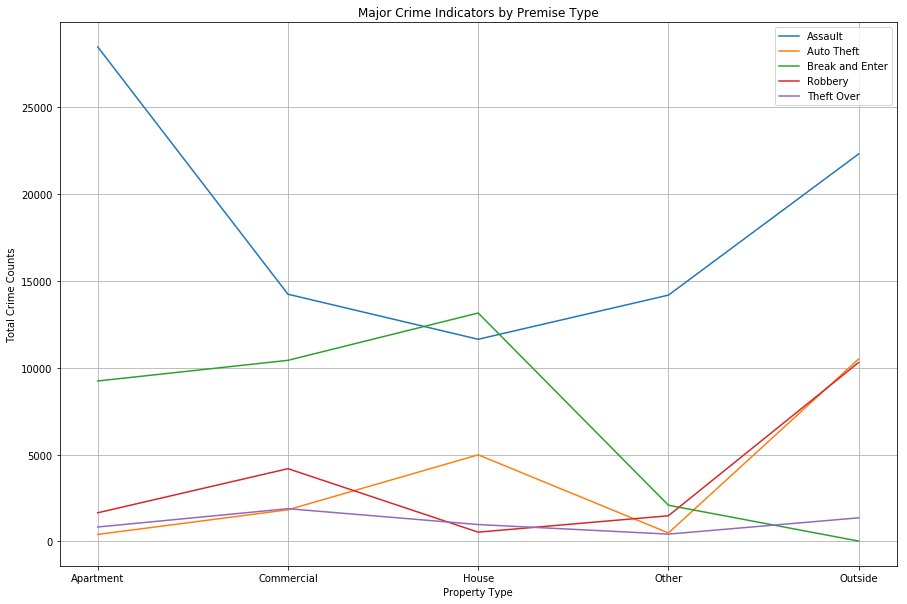

In [54]:
# Plot the premise type of 
MCI_df_Groupby_premisetype=MCI_df.groupby(["premisetype","MCI"])["ObjectId"].agg([("MCI count by premise type","count")]).reset_index(None)
MCI_df_Groupby_premisetype=MCI_df_Groupby_premisetype.set_index("MCI")

MCI_df_Groupby_premisetype_pivot=MCI_df_Groupby_premisetype.pivot(columns='premisetype',values="MCI count by premise type")

for i in range(len(MCI_df_Groupby_premisetype_pivot)):
   plt.plot([k for k in MCI_df_Groupby_premisetype_pivot.columns],[MCI_df_Groupby_premisetype_pivot[y].iloc[i] for y in MCI_df_Groupby_premisetype_pivot.columns])
plt.legend(MCI_df_Groupby_premisetype_pivot.index,loc="upper right")
plt.xlabel("Property Type")
plt.ylabel("Total Crime Counts")
plt.grid()
plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.title("Major Crime Indicators by Premise Type")
plt.savefig("Resources/Crime based on premise type1.png")
plt.show()


# Null hypothesis is no significance of crime on type of property.

The pvalue is lower than 0.05 hence we concluded to reject the null hypothesis

In [55]:
#Anova test for Occurance of Crime by type of property
# MCI_df_Groupby_premisetype_pivot
# groups_days=[]
# for i in range(len(MCI_df_Groupby_premisetype_pivot)):
#     groups_days.append([MCI_df_Groupby_premisetype_pivot[y].iloc[i] for y in MCI_df_Groupby_premisetype_pivot.columns])
# stats.f_oneway(groups_days[0], groups_days[1], groups_days[2], groups_days[3], groups_days[4])

df_result, pvalue = run_anova(MCI_df, "MCI", "premisetype")
df_result.to_html("premise_pivot_type.html")
print(f"pvalue = {pvalue}")

df_result, pvalue = run_anova(MCI_df, "premisetype", "MCI")
df_result.to_html("premise_pivot_mci.html")
print(f"pvalue = {pvalue}")

pvalue = 0.00014355566838504356
pvalue = 0.8693059740668914


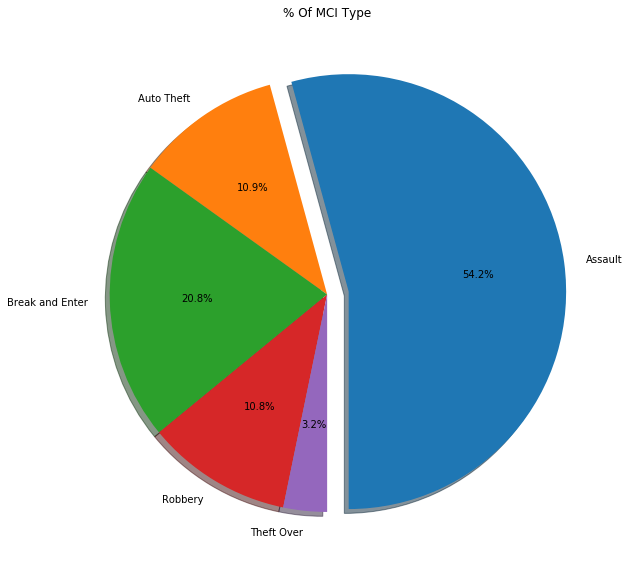

In [56]:
#Pie chart by crime 

MCI_df_crimeCount= MCI_df_household_chi_df=MCI_df.groupby(["MCI"])["ObjectId"].agg([("MCI Counts","count")\
                                                                               ]).reset_index(None)



explode = (0.1, 0, 0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

pieplt=plt.pie(MCI_df_crimeCount['MCI Counts'],explode=explode,labels=MCI_df_crimeCount['MCI'],autopct="%.1f%%",\
               shadow=True,startangle=270)

plt.title("% Of MCI Type")
plt.grid()
plt.savefig('Resources/Crime Break down.png')
plt.show()

In [57]:
top_df=MCI_df.groupby(["wardname"])["ObjectId"].agg([("MCI Counts","count")]).reset_index(None)
top_df

,wardname,MCI Counts
0,Beaches-East York (Ward 31),2686
1,Beaches-East York (Ward 32),4138
2,Davenport (Ward 17),2687
3,Davenport (Ward 18),3019
4,Don Valley East (Ward 33),2678
5,Don Valley East (Ward 34),2652
6,Don Valley West (Ward 25),2161
7,Don Valley West (Ward 26),2471
8,Eglinton-Lawrence (Ward 15),3896
9,Eglinton-Lawrence (Ward 16),1864


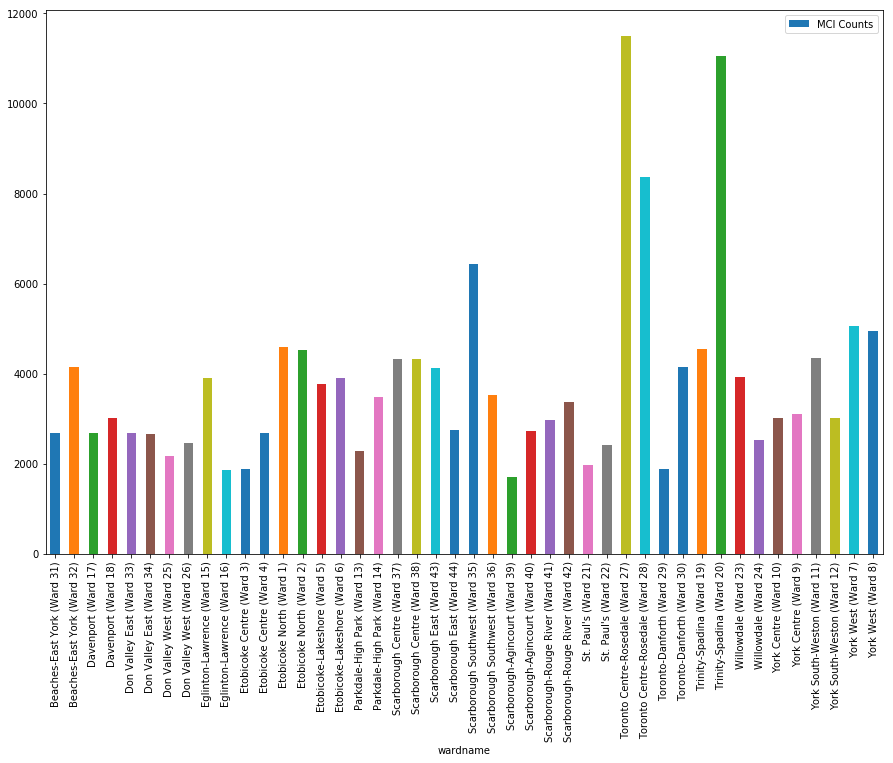

In [58]:
ax=top_df.plot.bar(x="wardname", y="MCI Counts",figsize=(15, 10), rot=90)
plt.savefig('Resources/crime across wards.png')
plt.show()

In [59]:
MCI_df.head(20)

,ObjectId,MCI,occurrencedate,premisetype,wardnumber,wardname,wardmedian,occurencedate_weekday,occurencedate_dayname,occurence hour of days
0,99462,Break and Enter,2015-04-08T17:15:00.000Z,House,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,2,Wednesday,17
1,140047,Assault,2016-03-06T15:00:00.000Z,House,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,6,Sunday,15
2,2404,Assault,2014-06-14T20:00:00.000Z,Outside,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,5,Saturday,20
3,48420,Assault,2015-08-13T03:30:00.000Z,Outside,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,3,Thursday,3
4,63103,Assault,2016-08-22T23:45:00.000Z,Outside,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,0,Monday,23
5,97455,Assault,2014-05-06T19:40:00.000Z,Outside,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,1,Tuesday,19
6,97456,Assault,2014-05-06T19:40:00.000Z,Outside,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,1,Tuesday,19
7,160653,Auto Theft,2018-02-24T18:00:00.000Z,Outside,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,5,Saturday,18
8,4411,Break and Enter,2015-02-01T09:00:00.000Z,House,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,6,Sunday,9
9,50246,Break and Enter,2015-12-14T10:00:00.000Z,House,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,0,Monday,10
